In [1]:
import torch
import gc

torch.cuda.empty_cache()

gc.collect()

30

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModel,
    get_linear_schedule_with_warmup,
    TrainerCallback
)
from torch.optim import SGD, RMSprop, AdamW
from sentence_transformers import (
    models,
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    SentenceTransformerModelCardData,
)
from sentence_transformers.losses import TripletLoss, MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator, SimilarityFunction

In [5]:
big_patent_dataset = load_dataset("json", data_files="/content/dataset_big_patent_v2.json")

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
big_patent_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'pos', 'neg'],
        num_rows: 499
    })
})

In [7]:
split_dataset = big_patent_dataset["train"].train_test_split(test_size=0.2)

# Second split: Temp into Test (10%) and Validation (10%)
temp_split = split_dataset["test"].train_test_split(test_size=0.5)

# Merge into final dataset
final_dataset = {
    "train": split_dataset["train"],
    "test": temp_split["test"],
    "validation": temp_split["train"],
}

In [8]:
train_dataset = final_dataset["train"]
test_dataset = final_dataset["test"]
eval_dataset = final_dataset["validation"]

In [9]:
checkpoint = "Lajavaness/bilingual-embedding-base"
config = AutoConfig.from_pretrained(checkpoint, trust_remote_code=True)
config.hidden_dropout_prob = 0.5
config.attention_probs_dropout_prob = 0.5

hf_model = AutoModel.from_pretrained(checkpoint, config=config, trust_remote_code=True)

transformer_model = models.Transformer(checkpoint)  # Initialize with the checkpoint
transformer_model.auto_model = hf_model

pooling_model = models.Pooling(transformer_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[transformer_model, pooling_model], trust_remote_code=True)

loss = MultipleNegativesRankingLoss(model)

config.json: 0.00B [00:00, ?B/s]

config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dangvantuan/bilingual_impl:
- config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dangvantuan/bilingual_impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

The repository for Lajavaness/bilingual-embedding-base contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/Lajavaness/bilingual-embedding-base.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [10]:
num_epochs = 5
num_train_steps = len(train_dataset) * num_epochs
num_warmup_steps = int(0.1 * num_train_steps)
optimizer = AdamW(params=model.parameters(), lr=5e-5, weight_decay=0.04)

lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_train_steps
)

optimizers = (optimizer, lr_scheduler)

In [11]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/Lajavaness/bilingual-embedding-base",
    # Optional training parameters:
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    #fp16=True,  # Set to False if your GPU can't handle FP16
    #bf16=False,  # Set to True if your GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # Losses using "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=10,
    #run_name="mpnet-base-all-nli-triplet",  # Used in W&B if `wandb` is installed
)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [12]:
dev_evaluator = TripletEvaluator(
    anchors=eval_dataset["query"],
    positives=eval_dataset["pos"],
    negatives=eval_dataset["neg"],
    main_similarity_function=SimilarityFunction.COSINE,
    name='eval'
)

dev_evaluator(model)

{'eval_cosine_accuracy': 0.800000011920929}

In [13]:
train_evaluator = TripletEvaluator(
        anchors=train_dataset["query"],
        positives=train_dataset["pos"],
        negatives=train_dataset["neg"],
        main_similarity_function=SimilarityFunction.COSINE,
        name='train'
    )

In [14]:
class EarlyStoppingCallback(TrainerCallback):
  def __init__(self, early_stop_threshold, train_evaluator):
    self.early_stop_threshold = early_stop_threshold
    self.train_evaluator = train_evaluator

  def on_evaluate(self, args, state, control, metrics, **kwargs):
    cos_acc = metrics.get("eval_cosine_accuracy", 0)

    if cos_acc > self.early_stop_threshold:
      print(f"Training stopped ! Desired validation accuracy reached {cos_acc:.2f}")
      control.should_training_stop = True

In [15]:
# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=[train_evaluator, dev_evaluator],
    optimizers=optimizers,
    callbacks=[EarlyStoppingCallback(early_stop_threshold=0.81, train_evaluator=train_evaluator)]
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Cosine Accuracy,Train Cosine Accuracy,Sequential Score
10,3.417800,0.814200,0.800000,0.716792,0.800000
20,3.373800,0.810443,0.800000,0.716792,0.800000
30,3.301400,0.800983,0.800000,0.719298,0.800000
40,3.212400,0.786720,0.820000,0.721804,0.820000


Training stopped ! Desired validation accuracy reached 0.82


TrainOutput(global_step=40, training_loss=3.3263418197631838, metrics={'train_runtime': 55.9536, 'train_samples_per_second': 57.047, 'train_steps_per_second': 3.574, 'total_flos': 0.0, 'train_loss': 3.3263418197631838, 'epoch': 1.6})

In [16]:
test_evaluator = TripletEvaluator(
    anchors=test_dataset["query"],
    positives=test_dataset["pos"],
    negatives=test_dataset["neg"],
    main_similarity_function=SimilarityFunction.COSINE,
    name="test",
)
test_evaluator(model)

{'test_cosine_accuracy': 0.6800000071525574}

In [17]:
model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BilingualModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Select first 100 examples
num_samples = 100

queries = [big_patent_dataset["train"][i]["query"] for i in range(num_samples)]
positives = [big_patent_dataset["train"][i]["pos"] for i in range(num_samples)]
negatives = [big_patent_dataset["train"][i]["neg"] for i in range(num_samples)]

# Get embeddings
query_embeddings = model.encode(queries, convert_to_tensor=False)
pos_embeddings = model.encode(positives, convert_to_tensor=False)
neg_embeddings = model.encode(negatives, convert_to_tensor=False)

# Stack all embeddings together
all_embeddings = np.vstack([query_embeddings, pos_embeddings, neg_embeddings])

In [19]:
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(all_embeddings)

In [20]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
embeddings_3d_tsne = tsne.fit_transform(all_embeddings)

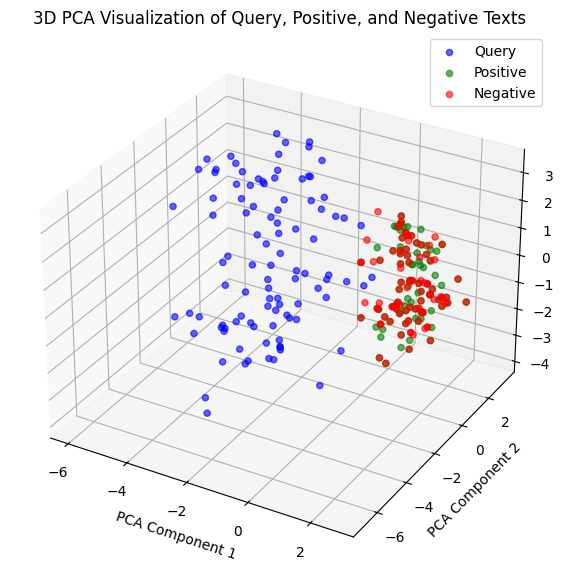

In [21]:
from mpl_toolkits.mplot3d import Axes3D

# Define colors
colors = ["blue"] * num_samples + ["green"] * num_samples + ["red"] * num_samples

# Create 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
ax.scatter(embeddings_3d[:num_samples, 0], embeddings_3d[:num_samples, 1], embeddings_3d[:num_samples, 2], color="blue", alpha=0.6, label="Query")
ax.scatter(embeddings_3d[num_samples:2*num_samples, 0], embeddings_3d[num_samples:2*num_samples, 1], embeddings_3d[num_samples:2*num_samples, 2], color="green", alpha=0.6, label="Positive")
ax.scatter(embeddings_3d[2*num_samples:, 0], embeddings_3d[2*num_samples:, 1], embeddings_3d[2*num_samples:, 2], color="red", alpha=0.6, label="Negative")

# Labels
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D PCA Visualization of Query, Positive, and Negative Texts")

# Legend
ax.legend()
plt.show()


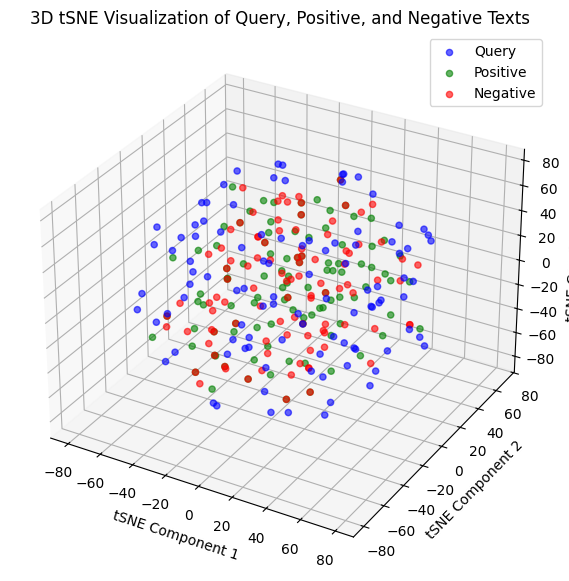

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Define colors
colors = ["blue"] * num_samples + ["green"] * num_samples + ["red"] * num_samples

# Create 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
ax.scatter(embeddings_3d_tsne[:num_samples, 0], embeddings_3d_tsne[:num_samples, 1], embeddings_3d_tsne[:num_samples, 2], color="blue", alpha=0.6, label="Query")
ax.scatter(embeddings_3d_tsne[num_samples:2*num_samples, 0], embeddings_3d_tsne[num_samples:2*num_samples, 1], embeddings_3d_tsne[num_samples:2*num_samples, 2], color="green", alpha=0.6, label="Positive")
ax.scatter(embeddings_3d_tsne[2*num_samples:, 0], embeddings_3d_tsne[2*num_samples:, 1], embeddings_3d_tsne[2*num_samples:, 2], color="red", alpha=0.6, label="Negative")

# Labels
ax.set_xlabel("tSNE Component 1")
ax.set_ylabel("tSNE Component 2")
ax.set_zlabel("tSNE Component 3")
ax.set_title("3D tSNE Visualization of Query, Positive, and Negative Texts")

# Legend
ax.legend()
plt.show()
